In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data=pd.read_csv("/content/drive/MyDrive/New/train_data.csv")
data.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1146412,1146412,Rue21 quarter sleeve,3,Women/Tops & Blouses/T-Shirts,rue,9.0,0,Quarter sleeve pink shirt. Stretchy material. ...
1,117583,117583,BCoppa77,2,Beauty/Bath & Body/Bath,NaN,5.0,1,No description yet
2,1242249,1242249,Baby Zara skinny jeans,3,Kids/Girls 0-24 Mos/Bottoms,NaN,12.0,1,Good condition Size 9-12 M
3,470404,470404,Jouer Skinny Dip Palette,1,Beauty/Makeup/Makeup Palettes,NaN,34.0,0,LE Skinny Dip Ultra Foil Shimmer Shadows Teste...
4,147937,147937,10k BLACK HILLS GOLD RING,3,Women/Jewelry/Rings,Stamped,44.0,0,Size 6 delicate heart BLACK HILLS GOLD RING. G...


# Observations:
Here Having 8 features in dataset in which price is our target variable.
The target variable have a continious values which means It's a regression machine learning model.
*   Train-id: id of the product (numerical)
*   Name: the title of the listing.(textual)
*   item_condition_id - the condition of the items provided by the seller (numerical)
*   category_name - category of the listing(categorical)
*   brand_name - brand of the product (categorical)
*   price - the price that the item was sold for. (target)
*   shipping - 1 if shipping fee is paid by seller and 0 by buyer(binary)
*   item_description - the full description of the item.(textual)

In [4]:
data.isnull().sum()


Unnamed: 0                0
train_id                  0
name                      0
item_condition_id         0
category_name          4462
brand_name           442900
price                     0
shipping                  0
item_description          2
dtype: int64

In [5]:
print("Number of Nan values in category_name: {}%".format((data['category_name'].isnull().sum()/data.shape[0])*100))
print("Number of Nan values in brand_name: {}%".format((data['brand_name'].isnull().sum()/data.shape[0])*100))
print("Number of Nan values in item_description: {}%".format((data['item_description'].isnull().sum()/data.shape[0])*100))

Number of Nan values in category_name: 0.4299587386078279%
Number of Nan values in brand_name: 42.67788555118937%
Number of Nan values in item_description: 0.0001927201876323747%


# Observations:

This dataset contains missing values which are usually known as NaN values before applying any model on such type of data it need to fill that data or simply make it as a empty strings.

*   Here there are 831 products with 0 price.
*   Their will be no product in the market with price <=0. They might be outliers or human errors.
*   So here we are removing the products with <=0 price.

Splitting the Training Data:

1.   Splitting up the data mainly useful for hyperparameter tuning part of machine learning.


In [6]:
data = data[data['price'] > 0].reset_index(drop=True)

In [7]:
data

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1146412,1146412,Rue21 quarter sleeve,3,Women/Tops & Blouses/T-Shirts,rue,9.0,0,Quarter sleeve pink shirt. Stretchy material. ...
1,117583,117583,BCoppa77,2,Beauty/Bath & Body/Bath,NaN,5.0,1,No description yet
2,1242249,1242249,Baby Zara skinny jeans,3,Kids/Girls 0-24 Mos/Bottoms,NaN,12.0,1,Good condition Size 9-12 M
3,470404,470404,Jouer Skinny Dip Palette,1,Beauty/Makeup/Makeup Palettes,NaN,34.0,0,LE Skinny Dip Ultra Foil Shimmer Shadows Teste...
4,147937,147937,10k BLACK HILLS GOLD RING,3,Women/Jewelry/Rings,Stamped,44.0,0,Size 6 delicate heart BLACK HILLS GOLD RING. G...
...,...,...,...,...,...,...,...,...,...
1037158,259178,259178,Brooks brothers girls,3,Kids/Girls (4+)/Dresses,Brooks Brothers,12.0,0,"Beautiful dress, another of her favorites. Sz...."
1037159,1414414,1414414,LulaRoe Randy size Large,1,Women/Tops & Blouses/Knit Top,NaN,34.0,0,"Brand new, never worn or washed, size Large, N..."
1037160,131932,131932,This sale is,1,Kids/Toys/Dolls & Accessories,NaN,99.0,0,American girl doll Tenney. Comes with the doll...
1037161,671155,671155,Iphone headphone lightning cable split,1,Electronics/Cell Phones & Accessories/Cables &...,Apple,9.0,0,No description yet


In [8]:
train=data.copy()

# Observations:

Here as seen that our data consists of Null values.
As a formost step it is needed to fill the Null values with the most prominent values.
We can see the category name consists of three subcategories in each row as a preprocessing step let's make them into three different categories and filling the Nan values with empty string values.
this function splits the category_name into further three sub_categories.

In [9]:

def handle_category(data):

  cat1=[]
  cat2=[]
  cat3=[]
  i=0
  for row in data:
    try:
      categories=row.split('/')
    except:
      categories=['','','']
    cat1.append(categories[0])
    cat2.append(categories[1])
    cat3.append(categories[2])
    i+=1
  return cat1,cat2,cat3

In [10]:
c1,c2,c3=handle_category(train['category_name'])
train['sub_category1']=c1
train['sub_category2']=c2
train['sub_category3']=c3

In [11]:
train['item_description'].fillna(value='No description given',inplace=True)
train['brand_name'].fillna(value='Not known',inplace=True)
train.isnull().sum()


Unnamed: 0              0
train_id                0
name                    0
item_condition_id       0
category_name        4454
brand_name              0
price                   0
shipping                0
item_description        0
sub_category1           0
sub_category2           0
sub_category3           0
dtype: int64

# Feature Engineering¶
Let's take count of number of words in the item_description. As the next feature engineering task let's use count of words,and sentiment score analysis as the new features.

# Feature Engineering
Is_branded:

Here most of the products don't have brand.That can be used as a feature for our data. We know that a product with different brands vary with their price. This is based on the company which it is producing. A good brand will have a good price compared to the same product of different brand. Therefore two similar products with different brands(known brand,unknown brand) can help us to know the price of the product. If it's a branded product then it has a value of 1 else it has a value of 0.

In [12]:
def branded(data):
   """this function assigns a value 1 if a product has brand_name else 0"""
   is_branded=[]
   for i in data['brand_name']:
      if i=='Not known': is_branded.append(0) #if it is a Nan value i.e.. unknown brand make it as 0.
      else: is_branded.append(1)
   return is_branded

train['is_branded']=branded(train)

In [13]:
train

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,sub_category1,sub_category2,sub_category3,is_branded
0,1146412,1146412,Rue21 quarter sleeve,3,Women/Tops & Blouses/T-Shirts,rue,9.0,0,Quarter sleeve pink shirt. Stretchy material. ...,Women,Tops & Blouses,T-Shirts,1
1,117583,117583,BCoppa77,2,Beauty/Bath & Body/Bath,Not known,5.0,1,No description yet,Beauty,Bath & Body,Bath,0
2,1242249,1242249,Baby Zara skinny jeans,3,Kids/Girls 0-24 Mos/Bottoms,Not known,12.0,1,Good condition Size 9-12 M,Kids,Girls 0-24 Mos,Bottoms,0
3,470404,470404,Jouer Skinny Dip Palette,1,Beauty/Makeup/Makeup Palettes,Not known,34.0,0,LE Skinny Dip Ultra Foil Shimmer Shadows Teste...,Beauty,Makeup,Makeup Palettes,0
4,147937,147937,10k BLACK HILLS GOLD RING,3,Women/Jewelry/Rings,Stamped,44.0,0,Size 6 delicate heart BLACK HILLS GOLD RING. G...,Women,Jewelry,Rings,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037158,259178,259178,Brooks brothers girls,3,Kids/Girls (4+)/Dresses,Brooks Brothers,12.0,0,"Beautiful dress, another of her favorites. Sz....",Kids,Girls (4+),Dresses,1
1037159,1414414,1414414,LulaRoe Randy size Large,1,Women/Tops & Blouses/Knit Top,Not known,34.0,0,"Brand new, never worn or washed, size Large, N...",Women,Tops & Blouses,Knit Top,0
1037160,131932,131932,This sale is,1,Kids/Toys/Dolls & Accessories,Not known,99.0,0,American girl doll Tenney. Comes with the doll...,Kids,Toys,Dolls & Accessories,0
1037161,671155,671155,Iphone headphone lightning cable split,1,Electronics/Cell Phones & Accessories/Cables &...,Apple,9.0,0,No description yet,Electronics,Cell Phones & Accessories,Cables & Adapters,1


In [14]:
train.columns

Index(['Unnamed: 0', 'train_id', 'name', 'item_condition_id', 'category_name',
       'brand_name', 'price', 'shipping', 'item_description', 'sub_category1',
       'sub_category2', 'sub_category3', 'is_branded'],
      dtype='object')

In [15]:
train.drop(columns=['Unnamed: 0', 'train_id'], inplace=True)

In [16]:
from contextlib import contextmanager

import keras as ks
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf


from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import KFold

In [17]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [18]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['text'] = df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna('')
    return df[['name', 'text', 'shipping', 'item_condition_id']]

In [19]:
def load_train(train):

#     train = pd.read_table('train.tsv')
    train = train[train['price'] > 0].reset_index(drop=True)
    cv = KFold(n_splits=20, shuffle=True, random_state=42)
    train_ids, valid_ids = next(cv.split(train))
    train, valid = train.iloc[train_ids], train.iloc[valid_ids]

    global y_scaler
    y_scaler = StandardScaler()

    global train_price, valid_price
    train_price = train['price'].values.reshape(-1, 1)
    valid_price = valid['price'].values.reshape(-1, 1)

    y_train = y_scaler.fit_transform(np.log1p(train_price))

    y_valid = y_scaler.transform(np.log1p(valid_price))

    train.drop(columns='price', inplace=True)
    valid.drop(columns='price', inplace=True)
    return train, valid, y_train, y_valid

In [20]:
def process_train(train, valid):

    global vectorizer1, vectorizer2, vectorizer3, vectorizer4
    with timer('process train'):
        train = preprocess(train)
        vectorizer1 = Tfidf(max_features=100000, token_pattern='\w+', dtype=np.float32)
        train_namevec  = vectorizer1.fit_transform(train['name'].values)

        vectorizer2 = Tfidf(max_features=100000, token_pattern='\w+', ngram_range=(1, 2), dtype=np.float32)
        train_textvec  = vectorizer2.fit_transform(train['text'].values)

        vectorizer3 = OneHotEncoder(dtype=np.float32)
        train_shipvec = vectorizer3.fit_transform(train['shipping'].values.reshape(-1, 1))

        vectorizer4 = OneHotEncoder(dtype=np.float32)
        train_conditionvec = vectorizer4.fit_transform(train['item_condition_id'].values.reshape(-1, 1))

        X_train = hstack((train_namevec, train_textvec, train_shipvec, train_conditionvec)).tocsr()

    with timer('process valid'):
        valid = preprocess(valid)

        valid_namevec  = vectorizer1.transform(valid['name'].values)

        valid_textvec  = vectorizer2.transform(valid['text'].values)

        valid_shipvec = vectorizer3.transform(valid['shipping'].values.reshape(-1, 1))

        valid_conditionvec = vectorizer4.transform(valid['item_condition_id'].values.reshape(-1, 1))

        X_valid = hstack((valid_namevec, valid_textvec, valid_shipvec, valid_conditionvec)).tocsr()


    return X_train, X_valid

In [21]:
data = train.copy()

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


In [23]:
# !pip3 install mxnet-mkl==1.6.0 numpy==1.23.1
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import time
from datetime import datetime
from keras.models import load_model

In [24]:
def give_train():
    return train

In [46]:
X_train, X_valid, y_train, y_valid = load_train(train)

In [47]:
X_train

,name,item_condition_id,category_name,brand_name,shipping,item_description,sub_category1,sub_category2,sub_category3,is_branded
0,Rue21 quarter sleeve,3,Women/Tops & Blouses/T-Shirts,rue,0,Quarter sleeve pink shirt. Stretchy material. ...,Women,Tops & Blouses,T-Shirts,1
1,BCoppa77,2,Beauty/Bath & Body/Bath,Not known,1,No description yet,Beauty,Bath & Body,Bath,0
2,Baby Zara skinny jeans,3,Kids/Girls 0-24 Mos/Bottoms,Not known,1,Good condition Size 9-12 M,Kids,Girls 0-24 Mos,Bottoms,0
3,Jouer Skinny Dip Palette,1,Beauty/Makeup/Makeup Palettes,Not known,0,LE Skinny Dip Ultra Foil Shimmer Shadows Teste...,Beauty,Makeup,Makeup Palettes,0
4,10k BLACK HILLS GOLD RING,3,Women/Jewelry/Rings,Stamped,0,Size 6 delicate heart BLACK HILLS GOLD RING. G...,Women,Jewelry,Rings,1
...,...,...,...,...,...,...,...,...,...,...
1037157,Men's down vest,2,Men/Coats & Jackets/Vest,Hawke & Co,1,Hawke & Co. men's down vest. Never worn. Perfe...,Men,Coats & Jackets,Vest,1
1037158,Brooks brothers girls,3,Kids/Girls (4+)/Dresses,Brooks Brothers,0,"Beautiful dress, another of her favorites. Sz....",Kids,Girls (4+),Dresses,1
1037159,LulaRoe Randy size Large,1,Women/Tops & Blouses/Knit Top,Not known,0,"Brand new, never worn or washed, size Large, N...",Women,Tops & Blouses,Knit Top,0
1037161,Iphone headphone lightning cable split,1,Electronics/Cell Phones & Accessories/Cables &...,Apple,0,No description yet,Electronics,Cell Phones & Accessories,Cables & Adapters,1


In [48]:

X_train, X_valid = process_train(X_train, X_valid)

[process train] done in 132 s
[process valid] done in 6 s


In [49]:
print(y_train)

[[-0.90924159]
 [-1.59476638]
 [-0.55715039]
 ...
 [ 0.77195848]
 [-0.90924159]
 [-0.1971418 ]]


In [50]:
import scipy.sparse
X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
X_valid = pd.DataFrame.sparse.from_spmatrix(X_valid)


In [42]:
X_train = X_train[:10000]


In [43]:
X_train.shape

(10000, 184605)

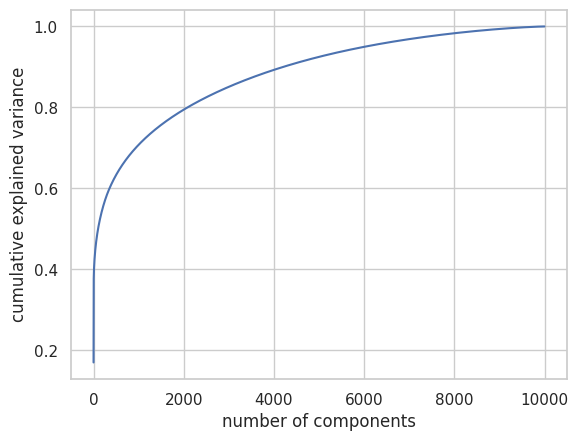

None

In [44]:
from sklearn.decomposition import KernelPCA
kpca_test = KernelPCA()
kpca_test = kpca_test.fit_transform(X_train)
explained_variance = np.var(kpca_test, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

sns.set(style='whitegrid')
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
display(plt.show())

evr = explained_variance_ratio
cvr = np.cumsum(explained_variance_ratio)

In [45]:
kpca_df = pd.DataFrame()
kpca_df['Cumulative Variance Ratio'] = cvr
kpca_df['Explained Variance Ratio'] = evr
display(kpca_df[kpca_df['Cumulative Variance Ratio'] >= 0.95])

,Cumulative Variance Ratio,Explained Variance Ratio
6014,0.950013,2.159467e-05
6015,0.950035,2.159467e-05
6016,0.950056,2.158127e-05
6017,0.950078,2.158127e-05
6018,0.950100,2.158127e-05
...,...,...
9993,0.999995,1.208749e-06
9994,0.999996,1.141745e-06
9995,0.999997,1.007709e-06
9996,0.999998,8.736865e-07


In [36]:
kpca_test.shape

(1000, 999)

In [54]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=5,max_iter=2000)

In [56]:
X_train_new = X_train[:8000]
y_train_new = y_train[:8000]
X_valid_new = X_valid[:2000]
y_valid_new = y_valid[:2000]


In [57]:
mlp.fit(X_train_new, y_train_new)

MLPRegressor(hidden_layer_sizes=5, max_iter=2000)

In [58]:
y_pred = mlp.predict(X_valid_new)

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Mean Squared Error (MSE)
mse = mean_squared_error(y_valid_new, y_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_valid_new,y_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R²) or Coefficient of Determination
r2 = r2_score(y_valid_new, y_pred)
print("R-squared (R²):", r2)

# Explained Variance Score
explained_var = explained_variance_score(y_valid_new, y_pred)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 0.6132279900702011
Root Mean Squared Error (RMSE): 0.7830887498043891
Mean Absolute Error (MAE): 0.6076599644164191
R-squared (R²): 0.37435292488462724
Explained Variance Score: 0.37612728652089467


In [79]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

# Create an MLPRegressor model with desired hyperparameters
model = mlp

# Define the input features X and the target variable y

# Perform cross-validation with 5 folds
num_folds = 5
scores = cross_val_score(model, X_train_new, y_train_new, cv=num_folds, scoring='neg_mean_squared_error')

# Cross-validation returns negative mean squared error, so we take the absolute values
mse_scores = -scores

# Compute the mean and standard deviation of the cross-validation scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_mse)
# Print the results
print("Mean MSE:", mean_mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 0.6162103957389029
Root Mean Squared Error (RMSE): 0.7849906978677537
Standard Deviation of MSE: 0.03553142560012151
